In [1]:
import pandas as pd
import glob
from sklearn.metrics import classification_report, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoModelForSeq2SeqLM, AutoModelForCausalLM, AutoTokenizer
import torch
import torch.nn.functional as F

# Results & Analysis
- Omit R-100, Pair R, Omit 1b7
- Main Result - **DONE**
  - Result from `Pre-trained` and `Seen` languages on BLOOM, BLOOMZ, Bilingual BLOOMZ, and XSS BLOOMZ
  - Model size 560m & 1b1
- Effect of continual pre-training
  - Pre-trained & Seen performance
  - bilingual & xss
  - R-1000, R-10000, R-100000
  - Compared to BLOOMZ-560m, BLOOMZ-1b1, BLOOMZ-1b7, BLOOMZ-3b
- Effect of different instruction-alignment objectives:
  - mono, bilingual, xss, translation, biling-xss, pair, pair-xss, random-xss
  - evaluation on the seen and pre-trained languages
  - compared to BLOOMZ-560m & BLOOMZ-1b1
- Effect to other unseen languages
  - seen & unseen performance
  - bilingual & xss R-100000
  - Compared to BLOOMZ-560m, BLOOMZ-1b1, BLOOMZ-1b7, BLOOMZ-3b

In [2]:
%%time
pt_langs = ['eng', 'ind']
seen_langs = ['sun', 'jav', 'bug', 'ace', 'bjn', 'ban', 'min']

metrics = {
    'task': [], 'task_lang': [], 'task_lang_group': [], 
    'prompt_lang': [], 'prompt': [], 'model': [], 'acc': [],
    'macro_f1': [], 'macro_prec': [], 'macro_rec': [],
    'micro_f1': [], 'micro_prec': [], 'micro_rec': [],
    'weighted_f1': [], 'weighted_prec': [], 'weighted_rec': [],
}
for path in glob.glob('../outputs/*.csv'):
    if '_nusantara_text_' in path:
        task, meta = path.split('/')[-1].split('_nusantara_text_')
        try:
            prompt, model = meta[:-4].split('_')
        except:
            prompt, model, rehearse = meta[:-4].split('_')
            model = f'{model}-{rehearse}'
    elif  '_nusantara_pairs_' in path:
        task, meta = path.split('/')[-1].split('_nusantara_pairs_')
        try:
            prompt, model = meta[:-4].split('_')
        except:
            prompt, model, rehearse = meta[:-4].split('_')
            model = f'{model}-{rehearse}'
    elif 'nusa_kalimat_' in path:
        try:
            task, lang, prompt, model = path.split('/')[-1][:-4].split('nusa_kalimat_')[1].split('_')
        except:
            task, lang, prompt, model, rehearse = path.split('/')[-1][:-4].split('nusa_kalimat_')[1].split('_')
            model = f'{model}-{rehearse}'
        task = f'nusa_kalimat_{task}_{lang}'
    elif 'nusa_alinea_' in path:
        try:
            task, lang, prompt, model = path.split('/')[-1][:-4].split('nusa_alinea_')[1].split('_')
        except:
            task, lang, prompt, model, rehearse = path.split('/')[-1][:-4].split('nusa_alinea_')[1].split('_')
            model = f'{model}-{rehearse}'
        task = f'nusa_alinea_{task}_{lang}'
    elif 'xnli' in path:
        try:
            task, task_lang, prompt, model = path.split('/')[-1][:-4].split('_')
        except:
            task, task_lang, prompt, model, rehearse = path.split('/')[-1][:-4].split('_')
            model = f'{model}-{rehearse}'
        task = f'{task}_{task_lang}'
    else:
        raise ValueError('WHAT!!!!')
    
    df = pd.read_csv(path)
    cls_report = classification_report(df['Gold'], df['Pred'], output_dict=True, zero_division=0)
    micro_f1, micro_prec, micro_rec, _ = precision_recall_fscore_support(df['Gold'], df['Pred'], average='micro')

    task_lang = task.split('_')[-1]
    if task_lang in pt_langs:
        lang_group = 'pretrained'
    elif task_lang in seen_langs:
        lang_group = 'novel'
    else:
        lang_group = 'unseen'
        
    metrics['task'].append('_'.join(task.split('_')[:-1]))
    metrics['task_lang'].append(task_lang)
    metrics['task_lang_group'].append(lang_group)
    metrics['prompt_lang'].append(prompt[:2])
    metrics['prompt'].append(prompt)
    metrics['model'].append(model)
    metrics['acc'].append(cls_report['accuracy'])
    metrics['macro_f1'].append(cls_report['macro avg']['f1-score'])
    metrics['macro_prec'].append(cls_report['macro avg']['precision'])
    metrics['macro_rec'].append(cls_report['macro avg']['recall'])
    metrics['micro_f1'].append(micro_f1)
    metrics['micro_prec'].append(micro_prec)
    metrics['micro_rec'].append(micro_rec)
    metrics['weighted_f1'].append(cls_report['weighted avg']['f1-score'])
    metrics['weighted_prec'].append(cls_report['weighted avg']['precision'])
    metrics['weighted_rec'].append(cls_report['weighted avg']['recall'])

EmptyDataError: No columns to parse from file

In [3]:
mdf = pd.DataFrame(metrics)

mdf.loc[mdf['task'] == 'indolem', 'task_lang_group'] = 'pretrained'
mdf.loc[mdf['task'] == 'indolem', 'task_lang'] = 'ind'
mdf.loc[mdf['task'] == 'indolem', 'task'] = 'nusa_kalimat_senti'

mdf.loc[mdf['task'] == 'emot', 'task_lang_group'] = 'pretrained'
mdf.loc[mdf['task'] == 'emot', 'task_lang'] = 'ind'
mdf.loc[mdf['task'] == 'emot', 'task'] = 'nusa_kalimat_emot'

mdf.groupby(['model','prompt_lang']).size()

model                             prompt_lang
bilingual-bloomz-1b1-R-10000      EN              8
bilingual-bloomz-1b1-R-100000     EN              9
bilingual-bloomz-560m             EN              8
                                  ID             10
bilingual-bloomz-560m-R-100       EN             12
bilingual-bloomz-560m-R-1000      EN             11
bilingual-bloomz-560m-R-10000     EN              6
bilingual-bloomz-560m-R-100000    EN             12
bilingual-xss-bloomz-560m         EN             13
bloom-1b1                         EN             13
                                  ID              5
bloom-1b7                         EN             12
                                  ID              7
bloom-3b                          EN             17
                                  ID              9
bloom-560m                        EN             15
                                  ID              7
bloomz-1b1                        EN              7
                  

In [4]:
mdf.to_csv('raw_result.csv', index=False)

In [5]:
mdf.loc[(mdf['prompt_lang'] == 'EN') & (mdf['task'] != 'nusa_kalimat_emot'),:].groupby(['prompt_lang', 'model'])[['acc','macro_f1','micro_f1','weighted_f1']].mean()

acc  macro_f1  micro_f1  \
prompt_lang model                                                            
EN          bilingual-bloomz-1b1-R-10000      0.491000  0.422619  0.491000   
            bilingual-bloomz-1b1-R-100000     0.153342  0.038445  0.153342   
            bilingual-bloomz-560m             0.461194  0.339514  0.461194   
            bilingual-bloomz-560m-R-100       0.443379  0.312546  0.443379   
            bilingual-bloomz-560m-R-1000      0.431677  0.323993  0.431677   
            bilingual-bloomz-560m-R-10000     0.330657  0.222603  0.330657   
            bilingual-bloomz-560m-R-100000    0.408301  0.281610  0.408301   
            bilingual-xss-bloomz-560m         0.380489  0.283865  0.380489   
            bloom-1b1                         0.343797  0.176849  0.343797   
            bloom-1b7                         0.204454  0.090422  0.204454   
            bloom-3b                          0.362847  0.175065  0.362847   
            bloom-560m                        0.277830  0.136660  0.277830   
            bloomz-1b1                        0.388752  0.264652  0.388752   
            bloomz-1b7                        0.350454  0.213351  0.350454   
            bloomz-3b                         0.437790  0.314696  0.437790   
            bloomz-560m                       0.389063  0.337156  0.389063   
            majority                          0.389167  0.175088  0.389167   
            monolingual-bloomz-1b1-R-100000   0.333098  0.198823  0.333098   
            monolingual-bloomz-560m           0.273229  0.164145  0.273229   
            monolingual-bloomz-560m-R-100000  0.439312  0.330266  0.439312   
            pair-bloomz-1b1                   0.346858  0.246647  0.346858   
            pair-bloomz-560m                  0.447750  0.374090  0.447750   
            pair-bloomz-560m-R-100            0.359815  0.230955  0.359815   
            pair-bloomz-560m-R-1000           0.377878  0.287329  0.377878   
            pair-bloomz-560m-R-10000          0.448793  0.330502  0.448793   
            pair-bloomz-560m-R-100000         0.283173  0.154100  0.283173   
            pair-xss-bloomz-560m              0.295638  0.189495  0.295638   
            random                            0.368750  0.366682  0.368750   
            random-bloomz-560m                0.292299  0.183575  0.292299   
            random-xss-bloomz-560m            0.330549  0.224160  0.330549   
            translation-bloomz-560m           0.319826  0.200417  0.319826   
            xss-bloomz-1b1-R-10000            0.334281  0.220101  0.334281   
            xss-bloomz-1b1-R-100000           0.399939  0.282259  0.399939   
            xss-bloomz-560m                   0.317101  0.219053  0.317101   
            xss-bloomz-560m-R-100             0.493440  0.276178  0.493440   
            xss-bloomz-560m-R-1000            0.334121  0.242650  0.334121   
            xss-bloomz-560m-R-10000           0.426338  0.321911  0.426338   
            xss-bloomz-560m-R-100000          0.355102  0.247869  0.355102   

                                              weighted_f1  
prompt_lang model                                          
EN          bilingual-bloomz-1b1-R-10000         0.450209  
            bilingual-bloomz-1b1-R-100000        0.045306  
            bilingual-bloomz-560m                0.380292  
            bilingual-bloomz-560m-R-100          0.364894  
            bilingual-bloomz-560m-R-1000         0.362749  
            bilingual-bloomz-560m-R-10000        0.252923  
            bilingual-bloomz-560m-R-100000       0.326073  
            bilingual-xss-bloomz-560m            0.310783  
            bloom-1b1                            0.217484  
            bloom-1b7                            0.083192  
            bloom-3b                             0.232571  
            bloom-560m                           0.160074  
            bloomz-1b1                           0.293532  
            bloomz-1b7        

# Task Aggregate

<AxesSubplot: xlabel='acc', ylabel='model'>

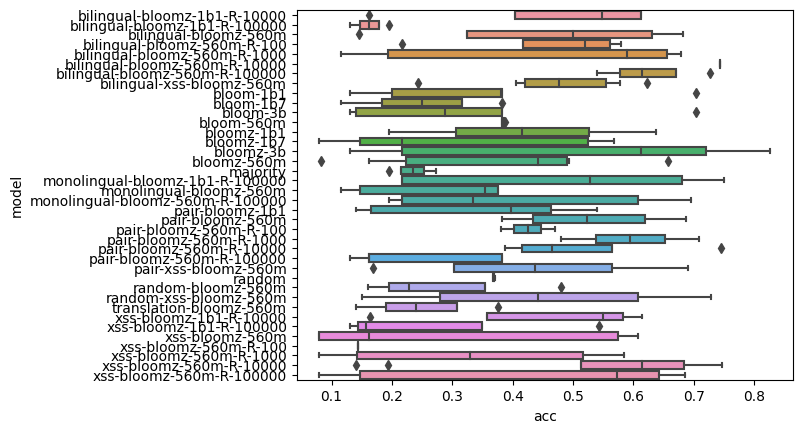

In [6]:
sns.boxplot(mdf.loc[
    (mdf['prompt_lang'] == 'EN') & (mdf['task'] != 'nusa_kalimat_emot') & (mdf['task_lang'].isin(pt_langs + seen_langs)),:
].sort_values('model'), y='model', x='acc', whis=0.5)

<AxesSubplot: xlabel='weighted_f1', ylabel='model'>

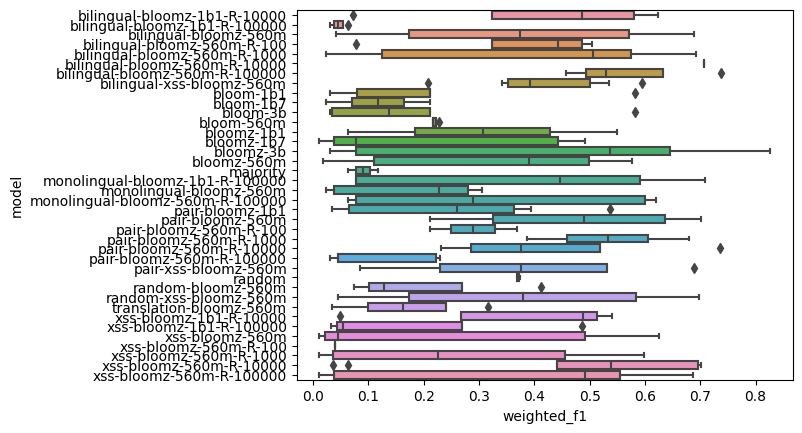

In [7]:
sns.boxplot(mdf.loc[
    (mdf['prompt_lang'] == 'EN') & (mdf['task'] != 'nusa_kalimat_emot') & (mdf['task_lang'].isin(pt_langs + seen_langs)),:
].sort_values('model'), y='model', x='weighted_f1', whis=0.5)

### Pretrained-Only

In [8]:
pt_langs = ['eng', 'ind']

<AxesSubplot: xlabel='acc', ylabel='model'>

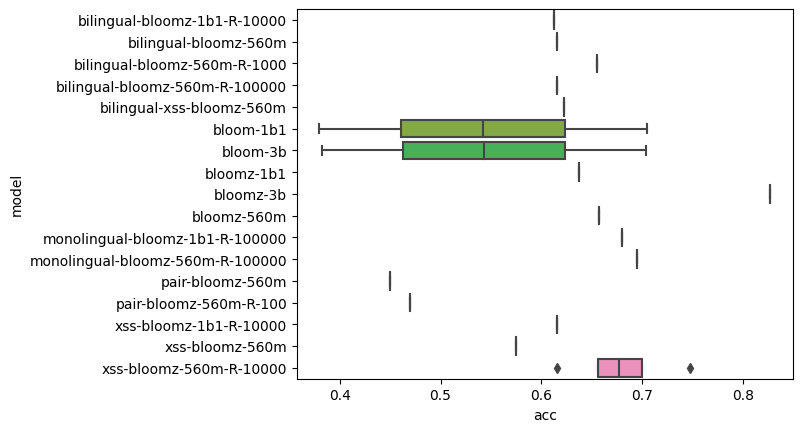

In [9]:
sns.boxplot(mdf.loc[
    (mdf['prompt_lang'] == 'EN') & (mdf['task'] != 'nusa_kalimat_emot') & (mdf['task_lang'].isin(pt_langs)),:
].sort_values('model'), y='model', x='acc', whis=0.5)

<AxesSubplot: xlabel='weighted_f1', ylabel='model'>

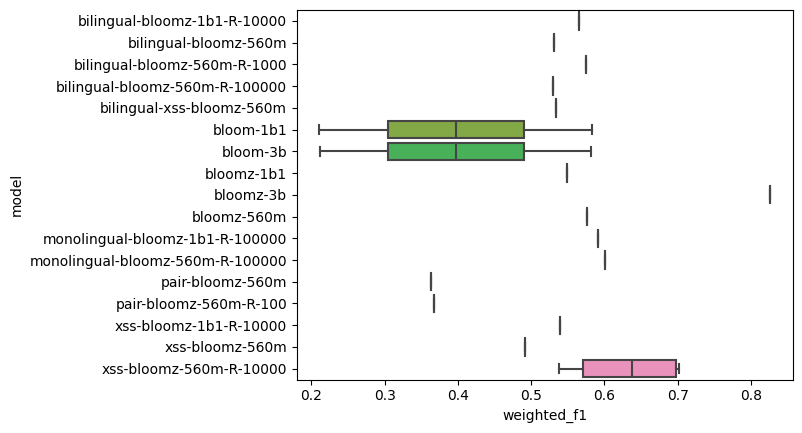

In [10]:
sns.boxplot(mdf.loc[
    (mdf['prompt_lang'] == 'EN') & (mdf['task'] != 'nusa_kalimat_emot') & (mdf['task_lang'].isin(pt_langs)),:
].sort_values('model'), y='model', x='weighted_f1', whis=0.5)

### Seen-Only

<AxesSubplot: xlabel='acc', ylabel='model'>

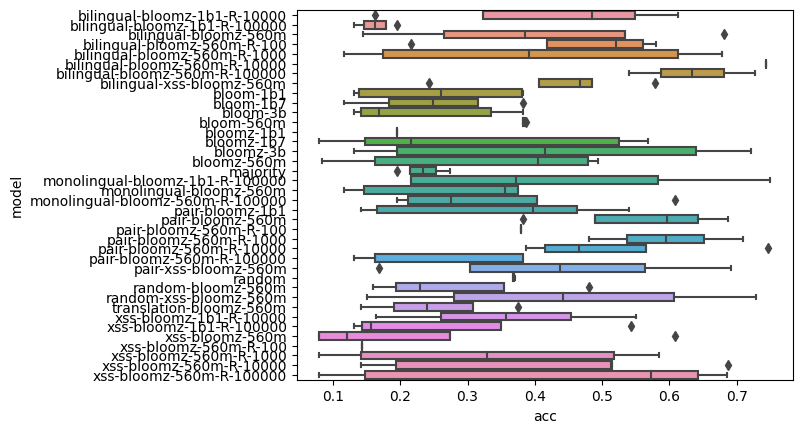

In [11]:
sns.boxplot(
    mdf.loc[
        (mdf['prompt_lang'] == 'EN')  & (mdf['task'] != 'nusa_kalimat_emot') & (mdf['task_lang'].isin(seen_langs)),:
    ].sort_values('model'),
y='model', x='acc', whis=0.5)

<AxesSubplot: xlabel='weighted_f1', ylabel='model'>

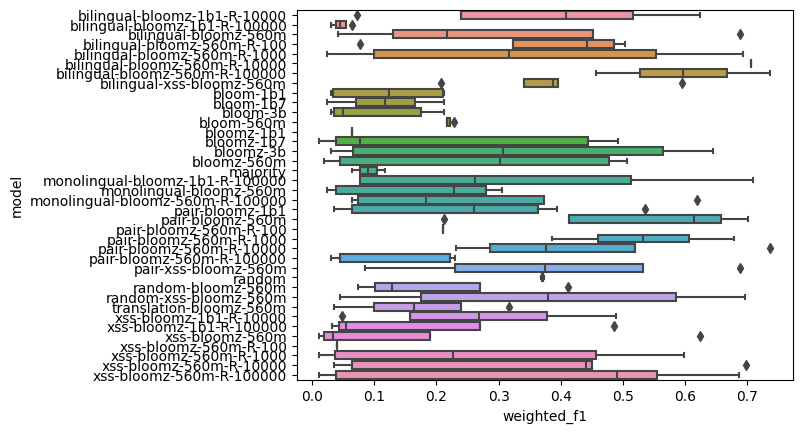

In [12]:
sns.boxplot(
    mdf.loc[
        (mdf['prompt_lang'] == 'EN') & (mdf['task'] != 'nusa_kalimat_emot') & (mdf['task_lang'].isin(seen_langs)),:
    ].sort_values('model'),
y='model', x='weighted_f1', whis=0.5)

### Unseen-Only

<AxesSubplot: xlabel='acc', ylabel='model'>

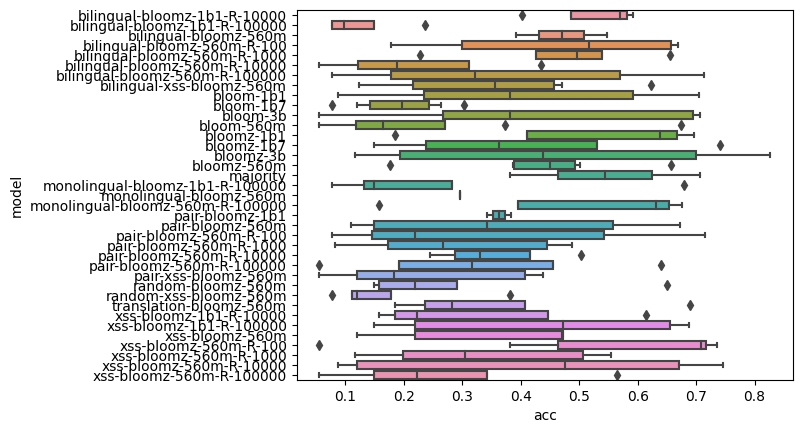

In [13]:
sns.boxplot(
    mdf.loc[
        (mdf['task'].str.startswith('nusa')) & (mdf['task'] != 'nusa_kalimat_emot') & (mdf['prompt_lang'] == 'EN') & (~mdf['task_lang'].isin(seen_langs + ['eng'])),:
    ].sort_values('model'),
y='model', x='acc', whis=0.5)

<AxesSubplot: xlabel='weighted_f1', ylabel='model'>

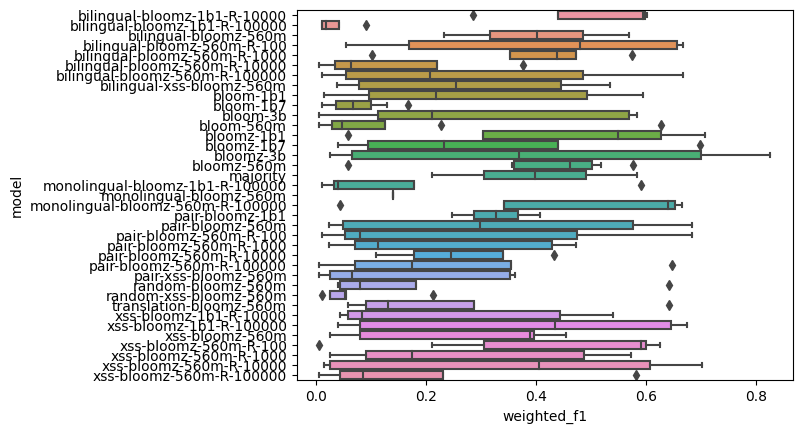

In [14]:
sns.boxplot(
    mdf.loc[
        (mdf['task'].str.startswith('nusa'))  & (mdf['task'] != 'nusa_kalimat_emot') & (mdf['prompt_lang'] == 'EN') & (~mdf['task_lang'].isin(seen_langs + ['eng'])),:
    ].sort_values('model'),
y='model', x='weighted_f1', whis=0.5)

# Analyze model per task group

In [15]:
mdf.loc[
    (mdf['task'].str.startswith('nusax'))  & (mdf['prompt_lang'] == 'EN')
,:].groupby(['model'])[['acc','macro_f1','micro_f1','weighted_f1']].mean()

,acc,macro_f1,micro_f1,weighted_f1
model,,,,
bilingual-bloomz-1b1-R-10000,0.503819,0.409092,0.503819,0.442707
bilingual-bloomz-1b1-R-100000,0.602847,0.478201,0.602847,0.534966
bilingual-bloomz-560m,0.466458,0.313486,0.466458,0.357923
bilingual-bloomz-560m-R-100,0.542222,0.408337,0.542222,0.465406
bilingual-bloomz-560m-R-1000,0.509514,0.375170,0.509514,0.424073
bilingual-bloomz-560m-R-10000,0.512153,0.385060,0.512153,0.434484
bilingual-bloomz-560m-R-100000,0.522153,0.388720,0.522153,0.443107
bilingual-xss-bloomz-560m,0.501597,0.367122,0.501597,0.418092
bloom-1b1,0.382847,0.194854,0.382847,0.219993


In [16]:
mdf.loc[
    mdf['task'].str.startswith('nusa_kalimat_emot') & (mdf['prompt_lang'] == 'EN'),:
].groupby(['model'])[['acc','macro_f1','micro_f1','weighted_f1']].mean()

,acc,macro_f1,micro_f1,weighted_f1
model,,,,
bilingual-bloomz-1b1-R-10000,0.231899,0.120299,0.231899,0.126675
bilingual-bloomz-1b1-R-100000,0.216051,0.071747,0.216051,0.077484
bilingual-bloomz-560m,0.215657,0.070931,0.215657,0.076661
bilingual-bloomz-560m-R-100,0.215936,0.071620,0.215936,0.077452
bilingual-bloomz-560m-R-1000,0.220101,0.106410,0.220101,0.108415
bilingual-bloomz-560m-R-10000,0.226323,0.109865,0.226323,0.116458
bilingual-bloomz-560m-R-100000,0.215603,0.071135,0.215603,0.076878
bilingual-xss-bloomz-560m,0.213865,0.078050,0.213865,0.081979
bloom-1b1,0.215747,0.071986,0.215747,0.077420


In [17]:
mdf.loc[
    mdf['task'].str.startswith('nusa_kalimat_senti') & (mdf['prompt_lang'] == 'EN'),:
].groupby(['model'])[['acc','macro_f1','micro_f1','weighted_f1']].mean()

,acc,macro_f1,micro_f1,weighted_f1
model,,,,
bilingual-bloomz-1b1-R-10000,0.505465,0.490593,0.505465,0.493344
bilingual-bloomz-1b1-R-100000,0.686025,0.565570,0.686025,0.654240
bilingual-bloomz-560m,0.639848,0.560477,0.639848,0.635835
bilingual-bloomz-560m-R-100,0.633172,0.565504,0.633172,0.632655
bilingual-bloomz-560m-R-1000,0.552182,0.532890,0.552182,0.547810
bilingual-bloomz-560m-R-10000,0.643864,0.550860,0.643864,0.627742
bilingual-bloomz-560m-R-100000,0.584066,0.500562,0.584066,0.543811
bilingual-xss-bloomz-560m,0.458328,0.444600,0.458328,0.429921
bloom-1b1,0.675631,0.425678,0.675631,0.576097


In [18]:
mdf.loc[
    mdf['task'].str.startswith('nusa_alinea_emot') & (mdf['prompt_lang'] == 'EN'),:
].groupby(['model'])[['acc','macro_f1','micro_f1','weighted_f1']].mean()

,acc,macro_f1,micro_f1,weighted_f1
model,,,,
bilingual-bloomz-1b1-R-10000,0.110733,0.028590,0.110733,0.023962
bilingual-bloomz-1b1-R-100000,0.110608,0.028393,0.110608,0.023785
bilingual-bloomz-560m,0.111025,0.029224,0.111025,0.024612
bilingual-bloomz-560m-R-100,0.129286,0.055625,0.129286,0.054117
bilingual-bloomz-560m-R-1000,0.110483,0.029089,0.110483,0.024358
bilingual-bloomz-560m-R-10000,0.111369,0.030018,0.111369,0.026100
bilingual-bloomz-560m-R-100000,0.110811,0.028753,0.110811,0.024195
bilingual-xss-bloomz-560m,0.163375,0.083118,0.163375,0.099946
bloom-1b1,0.110567,0.028216,0.110567,0.023623


In [19]:
mdf.loc[
    mdf['task'].str.startswith('nusa_alinea_topic') & (mdf['prompt_lang'] == 'EN'),:
].groupby(['model'])[['acc','macro_f1','micro_f1','weighted_f1']].mean()

,acc,macro_f1,micro_f1,weighted_f1
model,,,,
bilingual-bloomz-1b1-R-10000,0.199676,0.052599,0.199676,0.075626
bilingual-bloomz-1b1-R-100000,0.194063,0.041483,0.194063,0.065412
bilingual-bloomz-560m,0.196681,0.047108,0.196681,0.071186
bilingual-bloomz-560m-R-100,0.202668,0.055227,0.202668,0.079801
bilingual-bloomz-560m-R-1000,0.210023,0.098500,0.210023,0.121623
bilingual-bloomz-560m-R-10000,0.191855,0.046266,0.191855,0.069834
bilingual-bloomz-560m-R-100000,0.193657,0.041455,0.193657,0.065386
bilingual-xss-bloomz-560m,0.194644,0.043109,0.194644,0.067054
bloom-1b1,0.193944,0.040849,0.193944,0.064824


### Analyze language per task group

In [20]:
lang_map = {
       'btk': 'unseen', 'bew': 'unseen', 'bug': 'seen', 'jav': 'seen', 
       'mad': 'unseen', 'abs': 'unseen', 'min': 'seen', 'mak': 'unseen', 
       'bhp': 'unseen', 'mui': 'unseen', 'rej': 'unseen', 'ind': 'pretrained',
       'ban': 'seen', 'sun': 'seen', 'bbc': 'unseen', 'ace': 'seen',
       'nij': 'unseen', 'eng': 'pretrained', 'bjn': 'seen'
}

In [ ]:
mdf['lang_group'] = mdf['task_lang'].apply(lambda x: lang_map[x])

In [ ]:
mdf.loc[(mdf['task'].str.startswith('nusax_senti')),:].groupby(
    ['model', 'lang_group']
).mean().reset_index().pivot(
    'model','lang_group', 'weighted_f1'
    # ['model','lang'],'task', ['acc', 'macro_f1', 'micro_f1','weighted_f1']
)

In [ ]:
mdf.loc[(mdf['task'].str.startswith('nusa_kalimat_emot')),:].groupby(
    ['model', 'lang_group']
).mean().reset_index().pivot(
    'model','lang_group', 'weighted_f1'
    # ['model','lang'],'task', ['acc', 'macro_f1', 'micro_f1','weighted_f1']
)

In [ ]:
mdf.loc[(mdf['task'].str.startswith('nusa_kalimat_senti')),:].groupby(
    ['model', 'lang_group']
).mean().reset_index().pivot(
    'model','lang_group', 'weighted_f1'
    # ['model','lang'],'task', ['acc', 'macro_f1', 'micro_f1','weighted_f1']
)

In [ ]:
mdf.loc[(mdf['task'].str.startswith('nusa_alinea_emot')),:].groupby(
    ['model', 'lang_group']
).mean().reset_index().pivot(
    'model','lang_group', 'weighted_f1'
    # ['model','lang'],'task', ['acc', 'macro_f1', 'micro_f1','weighted_f1']
)

In [ ]:
mdf.loc[(mdf['task'].str.startswith('nusa_alinea_topic')),:].groupby(
    ['model', 'lang_group']
).mean().reset_index().pivot(
    'model','lang_group', 'weighted_f1'
    # ['model','lang'],'task', ['acc', 'macro_f1', 'micro_f1','weighted_f1']
)

### Analyze per task

In [12]:
mdf.groupby(
    ['model','task_lang','task']
).mean().reset_index().pivot(
    ['model','task_lang'],'task', ['acc', 'macro_f1', 'micro_f1','weighted_f1']
)

acc                        \
task                            nusa_kalimat_emot_abs nusa_kalimat_emot_bew   
model                 task_lang                                               
bilingual-bloomz-560m abs                    0.187778                   NaN   
                      ace                         NaN                   NaN   
                      ban                         NaN                   NaN   
                      bbc                         NaN                   NaN   
                      bew                         NaN                  0.19   
...                                               ...                   ...   
xss-bloomz-560m       min                         NaN                   NaN   
                      mui                         NaN                   NaN   
                      nij                         NaN                   NaN   
                      rej                         NaN                   NaN   
                      sun                         NaN                   NaN   

                                                                             \
task                            nusa_kalimat_emot_bhp nusa_kalimat_emot_btk   
model                 task_lang                                               
bilingual-bloomz-560m abs                         NaN                   NaN   
                      ace                         NaN                   NaN   
                      ban                         NaN                   NaN   
                      bbc                         NaN                   NaN   
                      bew                         NaN                   NaN   
...                                               ...                   ...   
xss-bloomz-560m       min                         NaN                   NaN   
                      mui                         NaN                   NaN   
                      nij                         NaN                   NaN   
                      rej                         NaN                   NaN   
                      sun                         NaN                   NaN   

                                                                             \
task                            nusa_kalimat_emot_jav nusa_kalimat_emot_mad   
model                 task_lang                                               
bilingual-bloomz-560m abs                         NaN                   NaN   
                      ace                         NaN                   NaN   
                      ban                         NaN                   NaN   
                      bbc                         NaN                   NaN   
                      bew                         NaN                   NaN   
...                                               ...                   ...   
xss-bloomz-560m       min                         NaN                   NaN   
                      mui                         NaN                   NaN   
                      nij                         NaN                   NaN   
                      rej                         NaN                   NaN   
                      sun                         NaN                   NaN   

                                                                             \
task                            nusa_kalimat_emot_mak nusa_kalimat_emot_min   
model                 task_lang                                               
bilingual-bloomz-560m abs                         NaN                   NaN   
                      ace                         NaN                   NaN   
                      ban                         NaN                   NaN   
                      bbc                         NaN                   NaN   
                      bew                         NaN                   NaN   
...                                               ...                   ...   
xss-bloomz-560m   

In [13]:
mdf.groupby(
    ['model','task_lang','task']
).mean().reset_index().pivot(
    ['model','task_lang'],'task', ['acc', 'macro_f1', 'micro_f1','weighted_f1']
).to_csv('result_zero_shot.csv', index=True)

In [14]:
dfs = []
for path in glob.glob('../metrics/*.csv'):
    lang, model = path[:-4].split('_')[2:4]
    df = pd.read_csv(path)
    df['lang'] = lang[:2]
    df['model'] = model
    dfs.append(df)
pd.concat(dfs).groupby(['model', 'lang']).mean()

accuracy  f1_score
model                   lang                    
bilingual-bloomz-560m   EN    0.441413  0.314921
                        ID    0.363408  0.289549
bloom-1b1               EN    0.423510  0.229781
                        ID    0.384121  0.205701
bloom-1b7               EN    0.371175  0.214207
                        ID    0.414412  0.259663
bloom-3b                EN    0.389846  0.205765
                        ID    0.341520  0.198875
bloom-560m              EN    0.400135  0.247659
                        ID    0.292523  0.175924
monolingual-bloomz-560m EN    0.326513  0.221513
                        ID    0.279636  0.214764
pair-bloomz-560m        EN    0.429605  0.311729
                        ID    0.322878  0.250424
pair-xss-bloomz-560m    EN    0.405212  0.301257
                        ID    0.323078  0.219956
random-bloomz-560m      EN    0.382428  0.272086
                        ID    0.282247  0.171598
random-xss-bloomz-560m  EN    0.412136  0.288649
                        ID    0.389504  0.304561
translation-bloomz-560m EN    0.377625  0.250638
                        ID    0.309332  0.242668
xss-bloomz-560m         EN    0.423198  0.320775
                        ID    0.366621  0.286182

# 32-bit

In [ ]:
metrics = {
    'task': [], 'lang': [], 'prompt': [], 'model': [], 'acc': [],
    'macro_f1': [], 'macro_prec': [], 'macro_rec': [],
    'micro_f1': [], 'micro_prec': [], 'micro_rec': []
}
for path in glob.glob('outputs_32bit/*.csv'):
    if '_nusantara_text_' in path:
        task, meta = path.split('/')[-1].split('_nusantara_text_')
    else:
        task, meta = path.split('/')[-1].split('_nusantara_pairs_')
    prompt, model = meta[:-4].split('_')
    
    df = pd.read_csv(path)
    cls_report = classification_report(df['Gold'], df['Pred'], output_dict=True)
    micro_f1, micro_prec, micro_rec, _ = precision_recall_fscore_support(df['Gold'], df['Pred'], average='micro')

    metrics['task'].append(task)
    metrics['lang'].append(prompt[:2])
    metrics['prompt'].append(prompt)
    metrics['model'].append(model)
    metrics['acc'].append(cls_report['accuracy'])
    metrics['macro_f1'].append(cls_report['macro avg']['f1-score'])
    metrics['macro_prec'].append(cls_report['macro avg']['precision'])
    metrics['macro_rec'].append(cls_report['macro avg']['recall'])
    metrics['micro_f1'].append(micro_f1)
    metrics['micro_prec'].append(micro_prec)
    metrics['micro_rec'].append(micro_rec)

In [ ]:
pd.DataFrame(metrics).groupby(['model','lang']).mean()

In [5]:
def get_logprobs(prompt):
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=1024).to('cuda')
    input_ids, output_ids = inputs["input_ids"], inputs["input_ids"][:, 1:]
    
    outputs = model(**inputs, labels=input_ids)
    logits = outputs.logits
    
    logprobs = torch.gather(F.log_softmax(logits, dim=2), 2, output_ids.unsqueeze(2))
    
    return logprobs.mean()

In [6]:
model = AutoModelForSeq2SeqLM.from_pretrained('bigscience/mt0-base')
tokenizer = AutoTokenizer.from_pretrained('bigscience/mt0-base')

In [ ]:
inputs = tokenizer('The emotion of "I am really glad that you are here. Thank you!" is', return_tensors='pt')
input_ids, output_ids = inputs["input_ids"], inputs["input_ids"][:, 1:]
outputs = model(**inputs, labels=input_ids)
x1 = F.log_softmax(outputs.logits, dim=2)
y1 = torch.gather(F.log_softmax(outputs.logits, dim=2), 2, output_ids.unsqueeze(2)).mean()

In [ ]:
model = AutoModelForCausalLM.from_pretrained('bigscience/bloomz-560m')
tokenizer = AutoTokenizer.from_pretrained('bigscience/mt0-base')

In [43]:
pd.concat(dfs).groupby(
    ['model','lang','index']
).mean().reset_index().pivot(
    ['model','lang'], 'index', ['accuracy', 'f1_score']
).to_csv('result_zero_shot.csv', index=True)

# Final Project

In [7]:
fp_df = mdf.loc[
    (~mdf['task'].str.startswith('xnli')) & ~mdf['task'].isin(['su_emot', 'indonli', 'indolem_sentiment', 'smsa', 'emot', 'imdb_jv'])
]

In [12]:
fp_df.sort_values(['task', 'model']).head(30)

,task,task_lang,prompt_lang,prompt,model,acc,macro_f1,macro_prec,macro_rec,micro_f1,micro_prec,micro_rec,weighted_f1,weighted_prec,weighted_rec
526,nusa_kalimat_emot_abs,abs,ID,ID3,bilingual-bloomz-560m,0.157778,0.083115,0.079770,0.205731,0.157778,0.157778,0.157778,0.076699,0.084122,0.157778
671,nusa_kalimat_emot_abs,abs,EN,EN,bilingual-bloomz-560m,0.208889,0.103098,0.152474,0.208018,0.208889,0.208889,0.208889,0.097275,0.158016,0.208889
1193,nusa_kalimat_emot_abs,abs,ID,ID,bilingual-bloomz-560m,0.146667,0.062306,0.100973,0.203905,0.146667,0.146667,0.146667,0.050782,0.111085,0.146667
1356,nusa_kalimat_emot_abs,abs,EN,EN2,bilingual-bloomz-560m,0.211111,0.080739,0.108559,0.204222,0.211111,0.211111,0.211111,0.080334,0.090420,0.211111
2107,nusa_kalimat_emot_abs,abs,EN,EN3,bilingual-bloomz-560m,0.208889,0.069118,0.041778,0.200000,0.208889,0.208889,0.208889,0.072190,0.043635,0.208889
2260,nusa_kalimat_emot_abs,abs,ID,ID2,bilingual-bloomz-560m,0.206667,0.122115,0.095712,0.236241,0.206667,0.206667,0.206667,0.123576,0.102352,0.206667
0,nusa_kalimat_emot_abs,abs,EN,EN2,bloomz-1b1,0.208889,0.069118,0.041778,0.200000,0.208889,0.208889,0.208889,0.072190,0.043635,0.208889
1611,nusa_kalimat_emot_abs,abs,ID,ID2,bloomz-1b1,0.233333,0.148112,0.113794,0.250385,0.233333,0.233333,0.233333,0.130836,0.098166,0.233333
1755,nusa_kalimat_emot_abs,abs,ID,ID3,bloomz-1b1,0.320000,0.218037,0.413753,0.290312,0.320000,0.320000,0.320000,0.222516,0.454712,0.320000
2034,nusa_kalimat_emot_abs,abs,EN,EN,bloomz-1b1,0.208889,0.069118,0.041778,0.200000,0.208889,0.208889,0.208889,0.072190,0.043635,0.208889


In [13]:
fp_df.groupby(['task', 'model']).size()

task                   model                   
nusa_kalimat_emot_abs  bilingual-bloomz-560m       6
                       bloomz-1b1                  6
                       bloomz-1b7                  6
                       bloomz-3b                   6
                       bloomz-560m                 6
                                                  ..
nusax_senti_sun        pair-bloomz-560m-R-100      6
                       pair-bloomz-560m-R-1000     6
                       pair-bloomz-560m-R-10000    6
                       random-bloomz-560m          6
                       translation-bloomz-560m     6
Length: 544, dtype: int64

### Per Task Result

### Catastrophic Forgetting

In [45]:
cf_models = ['pair-bloomz-560m','checkpoint-9740','checkpoint-19480', 'checkpoint-29220', 'checkpoint-38960']

In [46]:
cf_df = fp_df.loc[fp_df['model'].isin(cf_models)]

In [47]:
cf_df

,task,lang,prompt,model,acc,macro_f1,macro_prec,macro_rec,micro_f1,micro_prec,micro_rec,weighted_f1,weighted_prec,weighted_rec
1,nusax_senti_ace,ID,ID3,checkpoint-29220,0.337500,0.225947,0.221954,0.297321,0.337500,0.337500,0.337500,0.256942,0.252985,0.337500
5,nusa_kalimat_emot_mui,ID,ID3,checkpoint-19480,0.177778,0.102929,0.077812,0.200319,0.177778,0.177778,0.177778,0.102981,0.081851,0.177778
11,nusa_kalimat_senti_jav,ID,ID2,checkpoint-9740,0.342500,0.318982,0.509669,0.504498,0.342500,0.342500,0.342500,0.266883,0.597522,0.342500
19,nusa_kalimat_emot_mad,ID,ID,checkpoint-38960,0.240000,0.218514,0.242729,0.250257,0.240000,0.240000,0.240000,0.217395,0.250623,0.240000
21,nusa_kalimat_emot_btk,EN,EN2,checkpoint-19480,0.209000,0.069148,0.041842,0.199048,0.209000,0.209000,0.209000,0.072605,0.043934,0.209000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4045,nusa_kalimat_emot_bew,EN,EN2,checkpoint-29220,0.210000,0.069421,0.042000,0.200000,0.210000,0.210000,0.210000,0.072893,0.044100,0.210000
4049,nusa_kalimat_senti_btk,EN,EN,checkpoint-29220,0.419167,0.418872,0.516633,0.515850,0.419167,0.419167,0.419167,0.413490,0.604494,0.419167
4057,nusa_kalimat_senti_bhp,EN,EN,checkpoint-9740,0.534000,0.483029,0.492370,0.490873,0.534000,0.534000,0.534000,0.554453,0.589801,0.534000
4059,nusa_kalimat_senti_rej,EN,EN2,checkpoint-38960,0.446000,0.445501,0.510793,0.511339,0.446000,0.446000,0.446000,0.451955,0.587439,0.446000


### Related Work
#### Instruction-TUning 

#### Bilingual Alignment

#### Continual Learning

### Method
#### Instruct-Augment
- Token-Level language denoising (TLD) -> monolingual sentence completion
- Token-Level language alignment (TLA) -> contextualized sentence completion
- Sentence-level language alignment (SLA) -> machine translation
- In addition, we explore pair language alignment (PLA) method which combination of both contextualized sentence completion and machine translation, and monolingual-bilingual learning (MBL), which is a combination of all three methods.

#### Continual Learning -> Simple Rehearsal
- R-100, R-1000, R-10000

### Experiment
- 2000 parallel data for learning new languages
- We use instruction-tuned model, BLOOMZ, with only 560M parameters due to limited time and resource.
- We cover 6 languages that is not pre-trained on BLOOMZ, i.e., A, B, C, D, E, F.

### Results & Discussion
#### No Continual Learning
- Among the 3 basic methods (TLD, TLA, and SLA), TLA performs the best over all downstream tasks
- In terms of generalization to other languages, <Can-it-helps?>
- We observe forgetting problems on the other pre-learnt languages, i.e. English and Indonesian, we suspect this happens due to catastrophic forgetting

#### With Continual Learning
- 100 and 10,000 fails to improve the performance, but 1,000 improve the performance consistently on almost all tasks
   - Requires balancing between new tasks and old tasks.
- 

### Future Works
- Scale upp to larger size models
- 